In [168]:
import os
import pickle
import sys
from functools import partial

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.imitation.gail import gail
from rlib.algorithms.imitation.gcl import gcl
from rlib.algorithms.model_free.sac import sac
from rlib.common.env import CustomNNRewardWrapper
from rlib.common.evaluation import get_trajectory, validation
from rlib.common.policies import (
    Discriminator,
    DiscriminatorReward,
    MlpCritic,
    MlpQCritic,
    RewardNet,
    StochasticMlpPolicy,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Environment

In [143]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [144]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


### Expert

In [ ]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [ ]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=20_000,
)

In [ ]:
validation(env, actor)

-169.38176753538576

In [ ]:
with open("./models/pendulum_stoc_expert", "wb") as file:
    pickle.dump(actor, file)

### Expert Data

In [145]:
expert_data = torch.load("./models/pendulum_expert_data")

In [146]:
print(len(expert_data["observations"]))

600000


## GCL

### Train

In [67]:
learning_actor = StochasticMlpPolicy(obs_dim, action_dim)
critic = MlpCritic(obs_dim, action_dim)
reward_net = RewardNet(obs_dim, action_dim)

actor_optimizer = Adam(learning_actor.parameters(), lr=1e-4)
critic_optimizer = Adam(critic_1.parameters(), lr=1e-3)
reward_optimizer = Adam(reward_net.parameters(), lr=1e-4)

In [ ]:
gcl(
    env,
    expert_data,
    learning_actor,
    critic,
    reward_net,
    actor_optimizer,
    critic_optimizer,
    reward_optimizer,
)

In [91]:
with open("./models/pendulum_nn_gcl_reward", "wb") as file:
    pickle.dump(reward_net, file)

### Visualisation

In [ ]:
with open("./models/pendulum_nn_gcl_reward", "rb") as file:
    reward_net = pickle.load(file)

In [124]:
def original_reward(state, action):
    theta, theta_dot = state
    cost = theta**2 + 0.1 * theta_dot**2 + 0.001 * action**2
    return -cost

In [125]:
def nn_reward_wrapper(state, action, reward_net=reward_net):
    theta, thetadot = state
    observation = np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    observation_t = torch.tensor(observation.reshape(1, -1), dtype=torch.float32)
    action_t = torch.tensor(action.reshape(1, -1), dtype=torch.float32)

    reward_t = reward_net(observation_t, action_t)
    reward = reward_t.item()

    return reward

In [95]:
def plot_rewards(reward_fn):
    fig, axs = plt.subplots(ncols=3)

    theta_ls = np.linspace(-np.pi, np.pi)
    theta_dot_ls = np.linspace(-1, 1)
    action_ls = np.linspace(-1, 1)

    state = np.array([0, 0], dtype=np.float32)
    action = np.array(0)

    rewards = []
    for theta in theta_ls:
        state[0] = theta
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[0].plot(theta_ls, rewards)

    state = np.array([0, 0], dtype=np.float32)

    rewards = []
    for theta_dot in theta_dot_ls:
        state[1] = theta_dot
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[1].plot(theta_dot_ls, rewards)

    state = np.array([0, 0], dtype=np.float32)

    rewards = []
    for action in action_ls:
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[2].plot(action_ls, rewards)

    fig.tight_layout()

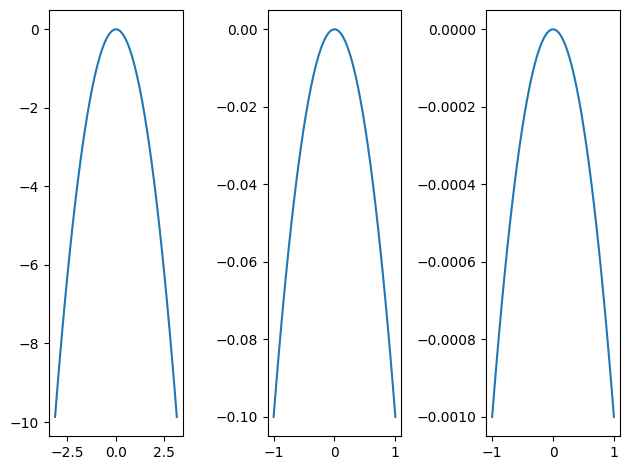

In [96]:
plot_rewards(original_reward)

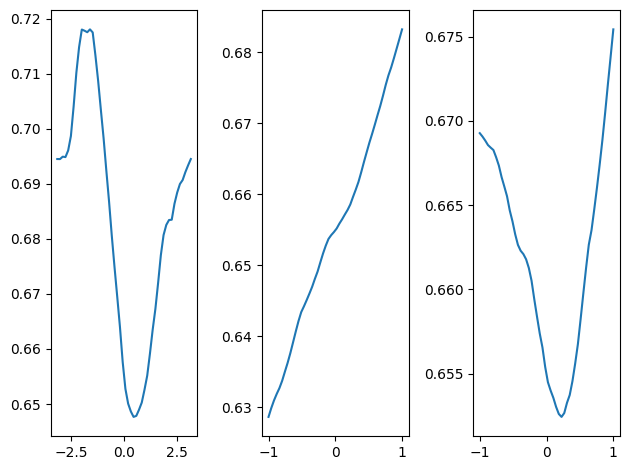

In [132]:
gcl_reward = partial(nn_reward_wrapper, reward_net=reward_net)
plot_rewards(gcl_reward)

### Learning agent from learned reward

In [102]:
with open("./models/pendulum_nn_reward", "rb") as file:
    reward_net = pickle.load(file)

In [103]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

env = CustomNNRewardWrapper(env, reward_net)

In [104]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [ ]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=30_000,
)

In [84]:
validation(env, actor, deterministic=True)

76.64483047481626

In [ ]:
get_trajectory(env, actor, visualize=True, filename="gcl_reward_agent.gif")

## GAIL

### Training

In [153]:
learning_actor = StochasticMlpPolicy(obs_dim, action_dim)
critic = MlpCritic(obs_dim, action_dim)
discriminator = Discriminator(obs_dim, action_dim)

actor_optimizer = Adam(learning_actor.parameters(), lr=1e-3)
critic_optimizer = Adam(critic_2.parameters(), lr=1e-3)
discriminator_optimizer = Adam(discriminator.parameters(), lr=1e-3)

In [154]:
gail(
    env,
    expert_data,
    learning_actor,
    critic,
    discriminator,
    actor_optimizer,
    critic_optimizer,
    discriminator_optimizer,
)

In [161]:
reward_net = DiscriminatorReward(discriminator)

with open("./models/pendulum_nn_gail_reward", "wb") as file:
    pickle.dump(reward_net, file)

### Visualization

In [164]:
with open("./models/pendulum_nn_gail_reward", "rb") as file:
    gail_reward = pickle.load(file)

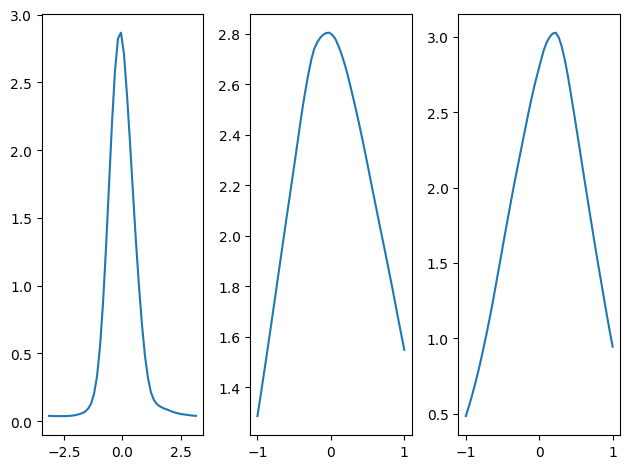

In [165]:
gail_reward = partial(nn_reward_wrapper, reward_net=gail_reward)

plot_rewards(gail_reward)